[check] F10 post rows present: 16 (should be >0 if included)
                          Trial_ID Condition
F10_post_t2_2025_04_27-01_40_37.h5   opto_es

[debug] Computed pre/post for F10 posts:
                              file prefix condition  Pre_Percent_Time_Swimming  Post_Percent_Time_Swimming
F10_post_t2_2025_04_27-01_40_37.h5    F10   opto_es                       6.10                        0.10

=== Per-prefix means (what the points show) ===
prefix condition  Pre_mean  Post_mean  Pre_median  Post_median  n_trials
    F1  es_alone      0.00      51.00        0.00        51.00         1
   F10  es_alone     51.15      81.45       51.15        81.45         2
   F11  es_alone     52.55      48.20       52.55        48.20         2
    F2  es_alone     40.25      43.60       40.25        43.60         2
    F8  es_alone     13.35      53.10       13.35        53.10         2
    F1   opto_es     22.70       0.00       22.70         0.00         1
   F10   opto_es      6.10       

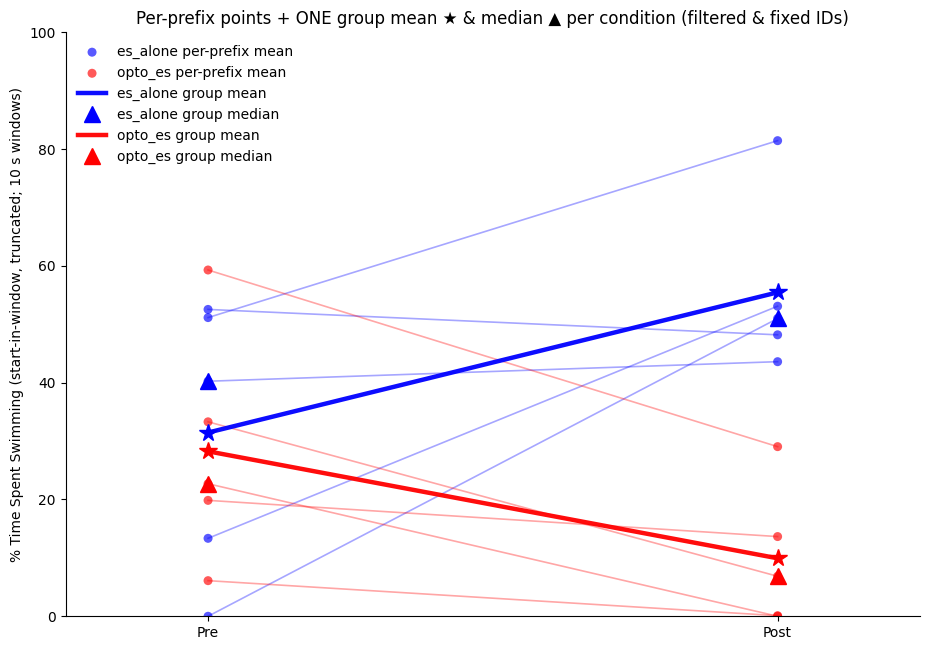

Saved figure:
 - C:\Maha\DATA\electric_stim\tracking_bout_detection\combined_prefix_points_plus_group_mean_median_FIXED_1.pdf 
 - C:\Maha\DATA\electric_stim\tracking_bout_detection\combined_prefix_points_plus_group_mean_median_FIXED_1.svg

=== Wilcoxon (one-sided) on per-prefix means (fixed IDs) ===
condition hypothesis  n_pairs  n_pos  n_neg  n_zero  median_delta(Post-Pre)  wilcoxon_stat  p_value            using
 es_alone   Post>Pre        5      4      1       0                    30.3              2  0.09375 per-prefix means
  opto_es   Pre>Post        5      0      5       0                   -22.7             15  0.03125 per-prefix means
Saved stats -> C:\Maha\DATA\electric_stim\tracking_bout_detection\wilcoxon_prefix_means_one_sided_FIXED.csv


In [17]:
# End-to-end script that:
# 1) robustly keeps the IDs/prefixes you want (fix for missing F10 posts),
# 2) computes Pre/Post % with the *start-in-window + truncation* rule,
# 3) aggregates to per-prefix means (one row per fish×condition),
# 4) plots per-prefix points + thick group mean (★) + group median (▲),
# 5) runs one-sided Wilcoxon on *per-prefix means* with your directions.

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ===================== CONFIG =====================
INPUT = Path(r"C:\Maha\DATA\electric_stim\tracking_bout_detection\electric_stim_tracking.csv")
OUT_DIR = Path(r"C:\Maha\DATA\electric_stim\tracking_bout_detection"); OUT_DIR.mkdir(parents=True, exist_ok=True)

SR = 100.0        # frames per second
STIM_START = 11.0 # seconds
WIN = 10.0        # seconds (Pre: [1,11), Post: [11,21))

# --- ID filtering (use either/both; leave empty to keep all) ---
# Fix: include the two F10 post files explicitly so they are NOT dropped.

KEEP_IDS = []


# Only these conditions (map 'es' -> 'es_alone').
# NOTE: we do NOT remap 'es_post' here; rows labeled 'es_post' will be dropped.
KEEP_CONDS = {"es_alone", "opto_es"}
COLOR = {"es_alone": "blue", "opto_es": "red"}

# Plot look
POINT_SIZE = 42
POINT_ALPHA = 0.65
PAIR_LINE_ALPHA = 0.35
PAIR_LINE_WIDTH = 1.2
GROUP_MEAN_LINE_WIDTH = 3.2
STAR_SIZE = 13   # group mean ★
TRI_SIZE = 12    # group median ▲

FIG_PDF = OUT_DIR / "combined_prefix_points_plus_group_mean_median_FIXED_1.pdf"
FIG_SVG = OUT_DIR / "combined_prefix_points_plus_group_mean_median_FIXED_1.svg"
STATS_CSV = OUT_DIR / "wilcoxon_prefix_means_one_sided_FIXED.csv"
# ===================================================

def need_cols(df: pd.DataFrame, cols):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise KeyError(f"Missing columns: {miss}. Available: {list(df.columns)}")

def extract_prefix(trial_id: str) -> str:
    m = re.match(r"^(F\d+)", str(trial_id).strip())
    return m.group(1) if m else str(trial_id).split("_")[0]

def sum_window_by_start(start_s, dur_s, a, b):
    """
    Sum truncated durations for bouts whose *start* lies in [a, b).
    Contribution per bout = min(dur_s, b - start_s), clipped to >= 0.
    """
    start_s = np.asarray(start_s, float)
    dur_s   = np.asarray(dur_s,   float)
    mask = (start_s >= a) & (start_s < b)
    if not np.any(mask):
        return 0.0, 0
    s = start_s[mask]; d = dur_s[mask]
    contrib = np.minimum(d, b - s).clip(min=0.0)
    return float(contrib.sum()), int(mask.sum())

# ---------------- LOAD & NORMALIZE ----------------
df = pd.read_csv(INPUT)

# normalize column names
if "Condition" not in df.columns and "condition" in df.columns:
    df = df.rename(columns={"condition": "Condition"})
if "condiiton" in df.columns and "Condition" not in df.columns:
    df = df.rename(columns={"condiiton": "Condition"})
if "Trial_ID" not in df.columns:
    for alt in ["file", "File", "TrialID", "trial_id"]:
        if alt in df.columns:
            df = df.rename(columns={alt: "Trial_ID"})
            break

need_cols(df, ["Trial_ID", "Condition", "BoutStart", "BoutEnd"])

# strip spaces; robust matching
df["Trial_ID"] = df["Trial_ID"].astype(str).str.strip()
df["Condition"] = df["Condition"].astype(str).str.strip().str.lower()

# --- FILTER by IDs/prefixes (union of both filters if both provided) ---
mask = pd.Series([True]*len(df))
if KEEP_IDS:
    ids_norm = {i.strip().casefold() for i in KEEP_IDS}
    mask_ids = df["Trial_ID"].str.casefold().isin(ids_norm)
    mask &= mask_ids
if KEEP_PREFIXES:
    pat = r"^(" + "|".join(map(re.escape, KEEP_PREFIXES)) + r")_"
    mask_pref = df["Trial_ID"].str.match(pat, case=False)
    mask &= mask_pref
df = df[mask].copy()
if df.empty:
    raise SystemExit("After ID/prefix filtering there are no rows. Check KEEP_IDS/KEEP_PREFIXES.")

# Confirm the two F10 post files are present (for your recent issue)
want = [
    "F10_post_t2_2025_04_27-01_40_37.h5",
    "F10_post_t1_2025_04_27-01_40_34.h5",
]
hit = df[df["Trial_ID"].str.casefold().isin({w.casefold() for w in want})]
print(f"[check] F10 post rows present: {len(hit)} (should be >0 if included)")
if not hit.empty:
    print(hit[["Trial_ID","Condition"]].drop_duplicates().to_string(index=False))

# condition mapping + filter
df["Condition"] = df["Condition"].replace({"es": "es_alone"})  # only map 'es'→'es_alone'
df = df[df["Condition"].isin(KEEP_CONDS)].copy()
if df.empty:
    raise SystemExit("After condition filtering (es_alone/opto_es) there are no rows.")

# Ensure numeric; frames → seconds
df["BoutStart"] = pd.to_numeric(df["BoutStart"], errors="coerce")
df["BoutEnd"]   = pd.to_numeric(df["BoutEnd"],   errors="coerce")
df = df.dropna(subset=["BoutStart","BoutEnd"]).copy()
df["start_s"] = df["BoutStart"] / SR
df["dur_s"]   = (df["BoutEnd"] - df["BoutStart"]) / SR
df["dur_s"]   = df["dur_s"].clip(lower=0)

# Windows
pre_a, pre_b   = STIM_START - WIN, STIM_START    # [1, 11)
post_a, post_b = STIM_START, STIM_START + WIN    # [11, 21)

# -------- PER-FILE (Trial_ID × Condition) PRE/POST % --------
rows = []
for (trial, cond), sub in df.groupby(["Trial_ID","Condition"], sort=False):
    s = sub["start_s"].to_numpy(float)
    d = sub["dur_s"].to_numpy(float)
    pre_sec,  _ = sum_window_by_start(s, d, pre_a,  pre_b)
    post_sec, _ = sum_window_by_start(s, d, post_a, post_b)
    rows.append({
        "file": trial,
        "prefix": extract_prefix(trial),
        "condition": cond,
        "Pre_Percent_Time_Swimming": 100.0 * min(pre_sec,  WIN) / WIN,
        "Post_Percent_Time_Swimming": 100.0 * min(post_sec, WIN) / WIN,
    })

per_file = pd.DataFrame(rows)
if per_file.empty:
    raise SystemExit("No rows after computing pre/post. Check filters and column names.")

# quick debug for the two F10 posts
dbg = per_file[per_file["file"].isin(want)]
if not dbg.empty:
    print("\n[debug] Computed pre/post for F10 posts:")
    print(dbg.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

# -------- PER-PREFIX (mean across that prefix’s trials) --------
prefix_mean = (
    per_file.groupby(["prefix","condition"], as_index=False)
            .agg(Pre_mean=("Pre_Percent_Time_Swimming","mean"),
                 Post_mean=("Post_Percent_Time_Swimming","mean"),
                 Pre_median=("Pre_Percent_Time_Swimming","median"),
                 Post_median=("Post_Percent_Time_Swimming","median"),
                 n_trials=("file","nunique"))
)

# -------- GROUP (across prefixes) one mean & median per condition --------
group = (
    prefix_mean.groupby("condition", as_index=False)
               .agg(Pre_mean=("Pre_mean","mean"),
                    Post_mean=("Post_mean","mean"),
                    Pre_median=("Pre_median","median"),
                    Post_median=("Post_median","median"),
                    n_prefix=("prefix","nunique"))
)

print("\n=== Per-prefix means (what the points show) ===")
print(prefix_mean.sort_values(["condition","prefix"]).to_string(index=False,
      float_format=lambda x: f"{x:.2f}"))

print("\n=== ONE group mean/median per condition (what the stars/triangles show) ===")
print(group.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

# ---------------- COMBINED PLOT ----------------
plt.figure(figsize=(9.4, 6.6))

# (1) per-prefix points + thin pair lines
for cond in ["es_alone", "opto_es"]:
    color = COLOR.get(cond, "tab:gray")
    sub = prefix_mean[prefix_mean["condition"] == cond].sort_values("prefix")
    if not sub.empty:
        plt.scatter(np.zeros(len(sub)), sub["Pre_mean"].to_numpy(float),
                    s=POINT_SIZE, alpha=POINT_ALPHA, color=color, edgecolors="none",
                    label=f"{cond} per-prefix mean")
        plt.scatter(np.ones(len(sub)),  sub["Post_mean"].to_numpy(float),
                    s=POINT_SIZE, alpha=POINT_ALPHA, color=color, edgecolors="none")
        for _, r in sub.iterrows():
            plt.plot([0, 1], [float(r["Pre_mean"]), float(r["Post_mean"])],
                     color=color, alpha=PAIR_LINE_ALPHA, linewidth=PAIR_LINE_WIDTH)

# (2) ONE group mean (★) & group median (▲); connect group means with thick line
for _, r in group.iterrows():
    cond = r["condition"]; color = COLOR.get(cond, "tab:gray")
    g_pre_mean, g_post_mean = float(r["Pre_mean"]),  float(r["Post_mean"])
    g_pre_med,  g_post_med  = float(r["Pre_median"]),float(r["Post_median"])
    plt.plot([0,1], [g_pre_mean, g_post_mean], color=color,
             linewidth=GROUP_MEAN_LINE_WIDTH, alpha=0.95, label=f"{cond} group mean")
    plt.plot(0, g_pre_mean,  marker="*", markersize=STAR_SIZE, color=color, linestyle="None")
    plt.plot(1, g_post_mean, marker="*", markersize=STAR_SIZE, color=color, linestyle="None")
    plt.plot(0, g_pre_med,   marker="^", markersize=TRI_SIZE,  color=color, linestyle="None", label=f"{cond} group median")
    plt.plot(1, g_post_med,  marker="^", markersize=TRI_SIZE,  color=color, linestyle="None")

# Cosmetics
vals = []
if not prefix_mean.empty:
    vals += prefix_mean[["Pre_mean","Post_mean","Pre_median","Post_median"]].to_numpy().ravel().tolist()
if not group.empty:
    vals += group[["Pre_mean","Post_mean","Pre_median","Post_median"]].to_numpy().ravel().tolist()
ymax = float(np.nanmax(vals)) if vals else 100.0

plt.xlim(-0.25, 1.25)
plt.ylim(0, max(100, ymax + 6))
plt.xticks([0, 1], ["Pre", "Post"])
plt.ylabel("% Time Spent Swimming (start-in-window, truncated; 10 s windows)")
plt.title("Per-prefix points + ONE group mean ★ & median ▲ per condition (filtered & fixed IDs)")
plt.legend(loc="best", frameon=False)
for spine in ["top","right"]:
    plt.gca().spines[spine].set_visible(False)
plt.tight_layout()
plt.savefig(FIG_PDF); plt.savefig(FIG_SVG)
plt.show()
print("Saved figure:\n -", FIG_PDF, "\n -", FIG_SVG)

# ---------------- WILCOXON (one-sided) on per-prefix means ----------------
# Use deltas (post - pre):
# es_alone: Post>Pre  => alternative='greater' on deltas
# opto_es : Pre>Post  => alternative='less'    on deltas
rows = []
for cond, alt in [("es_alone","greater"), ("opto_es","less")]:
    sub = prefix_mean[prefix_mean["condition"] == cond][["prefix","Pre_mean","Post_mean"]].dropna()
    pre  = sub["Pre_mean"].to_numpy(float)
    post = sub["Post_mean"].to_numpy(float)
    if len(pre) and len(post):
        try:
            # translate to (pre, post) call with correct alternative
            # if alt=='greater' (Post>Pre): pass (pre, post), alternative='less'
            # if alt=='less'    (Pre>Post): pass (pre, post), alternative='greater'
            alt_wx = "less" if alt=="greater" else "greater"
            res = stats.wilcoxon(pre, post, zero_method="pratt", alternative=alt_wx, method="auto")
        except TypeError:
            res = stats.wilcoxon(pre, post, zero_method="pratt", alternative=alt_wx)
        d = post - pre
        rows.append({
            "condition": cond,
            "hypothesis": "Post>Pre" if alt=="greater" else "Pre>Post",
            "n_pairs": int(len(d)),
            "n_pos": int((d>0).sum()),
            "n_neg": int((d<0).sum()),
            "n_zero": int((d==0).sum()),
            "median_delta(Post-Pre)": float(np.median(d)),
            "wilcoxon_stat": float(res.statistic),
            "p_value": float(res.pvalue),
            "using": "per-prefix means"
        })
stats_df = pd.DataFrame(rows)
print("\n=== Wilcoxon (one-sided) on per-prefix means (fixed IDs) ===")
if not stats_df.empty:
    print(stats_df.to_string(index=False, float_format=lambda x: f"{x:.6g}"))
    stats_df.to_csv(STATS_CSV, index=False)
    print("Saved stats ->", STATS_CSV)
else:
    print("No stats computed.")



In [18]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

# ========= CONFIG =========
OUT_DIR = Path(r"C:\Maha\DATA\electric_stim\tracking_bout_detection")
PER_FILE_CSV = OUT_DIR / "pre_post_per_file_mean.csv"  # has file, condition, Pre_Percent_Time_Swimming, Post_Percent_Time_Swimming
N_PERM = 20000     # iterations for permutation (increase if you want)
RNG_SEED = 42
DROP_ZEROS = False  # if True, drop pairs with Pre==0 or Post==0
# =========================

# ---- Load per-file table ----
if "per_file" in globals():
    df = per_file.copy()
else:
    df = pd.read_csv(PER_FILE_CSV)

# ---- Normalize columns ----
if "condition" not in df.columns and "Condition" in df.columns:
    df = df.rename(columns={"Condition":"condition"})
df["condition"] = df["condition"].astype(str).str.strip().str.lower().replace({"es":"es_alone"})
for c in ["Pre_Percent_Time_Swimming","Post_Percent_Time_Swimming"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# extract fish prefix (F8, F9, ...)
def get_prefix(name: str) -> str:
    m = re.match(r"^(F\d+)", str(name))
    return m.group(1) if m else str(name).split("_")[0]
df["prefix"] = df["file"].astype(str).map(get_prefix)

# ---- Collapse to per-prefix means (each fish once per condition) ----
prefix_mean = (
    df.groupby(["prefix","condition"], as_index=False)
      .agg(Pre_mean=("Pre_Percent_Time_Swimming","mean"),
           Post_mean=("Post_Percent_Time_Swimming","mean"))
)

# ---- Helpers to form paired arrays ----
def paired_arrays(dfp: pd.DataFrame, cond: str, drop_zeros=DROP_ZEROS):
    sub = dfp[dfp["condition"] == cond][["prefix","Pre_mean","Post_mean"]].dropna().copy()
    if drop_zeros:
        sub = sub[(sub["Pre_mean"] != 0) & (sub["Post_mean"] != 0)]
    pre  = sub["Pre_mean"].to_numpy(float)
    post = sub["Post_mean"].to_numpy(float)
    return sub, pre, post

# ---- Tests ----
def sign_test_one_sided(d, alternative: str):
    """
    One-sided exact sign test using binomial test on signs of d.
    alternative: 'greater' tests P(d>0) > 0.5 ; 'less' tests P(d>0) < 0.5
    Ties (d==0) are dropped.
    """
    from scipy.stats import binomtest
    d = np.asarray(d, float)
    nz = d[d != 0]
    n = nz.size
    if n == 0:
        return np.nan, 0, 0, 0
    k = int((nz > 0).sum())
    res = binomtest(k, n, 0.5, alternative=alternative)
    return float(res.pvalue), n, k, int((nz < 0).sum())

def paired_permutation_p(pre, post, alternative: str, n_iter=N_PERM, seed=RNG_SEED):
    """
    Paired permutation test on mean delta (post - pre).
    alternative='greater' -> tests mean(delta) > 0
    alternative='less'    -> tests mean(delta) < 0
    """
    rng = np.random.default_rng(seed)
    d = np.asarray(post, float) - np.asarray(pre, float)
    d = d[~np.isnan(d)]
    if d.size == 0:
        return np.nan
    obs = d.mean()
    # random sign flipping
    flips = rng.choice([-1.0, 1.0], size=(n_iter, d.size))
    sims = (flips * d).mean(axis=1)
    if alternative == "greater":
        p = (np.sum(sims >= obs) + 1) / (n_iter + 1)
    else:  # 'less'
        p = (np.sum(sims <= obs) + 1) / (n_iter + 1)
    return float(p)

def paired_t_test(pre, post, alternative: str):
    """
    Paired t-test on deltas. Reports Shapiro-Wilk p for normality of deltas.
    alternative='greater' => mean(post-pre) > 0 ; 'less' => < 0
    """
    from scipy.stats import ttest_rel, shapiro
    d = np.asarray(post, float) - np.asarray(pre, float)
    d = d[~np.isnan(d)]
    if d.size == 0:
        return np.nan, np.nan, 0
    # t-test (SciPy two-sided; convert to one-sided)
    t2 = ttest_rel(post, pre, nan_policy="omit")  # H0: mean(post-pre)=0
    t_stat = float(t2.statistic)
    p_two = float(t2.pvalue)
    if alternative == "greater":
        p_one = p_two/2 if t_stat > 0 else 1 - p_two/2
    else:  # 'less'
        p_one = p_two/2 if t_stat < 0 else 1 - p_two/2
    # normality of deltas
    sp = np.nan
    if d.size >= 3:
        try:
            sp = float(shapiro(d).pvalue)
        except Exception:
            pass
    return p_one, sp, d.size

def bootstrap_ci(d, stat="median", n_boot=20000, seed=RNG_SEED, alpha=0.05):
    """
    Percentile bootstrap CI for median or mean of delta.
    """
    rng = np.random.default_rng(seed)
    d = np.asarray(d, float)
    d = d[~np.isnan(d)]
    if d.size == 0:
        return np.nan, (np.nan, np.nan)
    boot = np.empty(n_boot)
    for i in range(n_boot):
        s = rng.choice(d, size=d.size, replace=True)
        boot[i] = np.median(s) if stat == "median" else np.mean(s)
    lo = np.percentile(boot, 100*alpha/2)
    hi = np.percentile(boot, 100*(1-alpha/2))
    return float((np.median(d) if stat=="median" else np.mean(d))), (float(lo), float(hi))

# ---- Run for both conditions with your directions ----
# Mapping on deltas d = post - pre
# es_alone: Post>Pre  -> alternative='greater'
# opto_es : Pre>Post  -> alternative='less'
SETTINGS = {
    "es_alone": "greater",
    "opto_es":  "less",
}

rows = []
for cond, alt in SETTINGS.items():
    sub, pre, post = paired_arrays(prefix_mean, cond, drop_zeros=DROP_ZEROS)
    d = post - pre

    # 1) Sign test
    p_sign, n_used, n_pos, n_neg = sign_test_one_sided(d, alternative=alt)

    # 2) Paired permutation
    p_perm = paired_permutation_p(pre, post, alternative=alt)

    # 3) Paired t-test (+ Shapiro p for deltas)
    p_t, p_shapiro, n_t = paired_t_test(pre, post, alternative=alt)

    # 4) Bootstrap CIs (mean & median of delta)
    mean_hat, mean_ci = bootstrap_ci(d, stat="mean")
    med_hat,  med_ci  = bootstrap_ci(d, stat="median")

    rows.append({
        "condition": cond,
        "direction": ("Post>Pre" if alt=="greater" else "Pre>Post"),
        "n_pairs": int(len(d)),
        "sign_p": p_sign,
        "sign_counts": f"pos={n_pos}, neg={n_neg}, used={n_used}",
        "perm_p": p_perm,
        "ttest_p": p_t,
        "shapiro_p(deltas)": p_shapiro,
        "delta_mean": mean_hat,
        "delta_mean_CI95": f"({mean_ci[0]:.2f},{mean_ci[1]:.2f})",
        "delta_median": med_hat,
        "delta_median_CI95": f"({med_ci[0]:.2f},{med_ci[1]:.2f})",
    })

out = pd.DataFrame(rows)
with pd.option_context("display.max_columns", None, "display.width", 140):
    print("\n=== Alternative stats on PER-FISH (per-prefix means) ===")
    print(out.to_string(index=False, float_format=lambda x: f"{x:.6g}"))



=== Alternative stats on PER-FISH (per-prefix means) ===
condition direction  n_pairs  sign_p          sign_counts    perm_p   ttest_p  shapiro_p(deltas)  delta_mean delta_mean_CI95  delta_median delta_median_CI95
 es_alone  Post>Pre        5  0.1875 pos=4, neg=1, used=5 0.0936453 0.0430895           0.558397       24.01    (5.66,42.36)          30.3     (-4.35,51.00)
  opto_es  Pre>Post        5 0.03125 pos=0, neg=5, used=5 0.0311984 0.0116739           0.160425      -18.32  (-27.22,-9.42)         -22.7    (-30.25,-6.00)


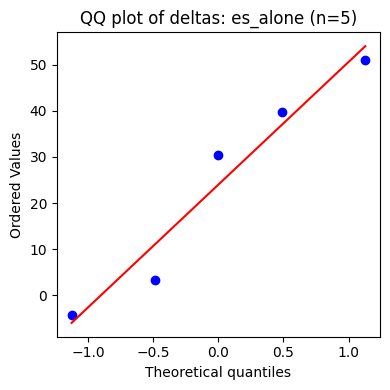

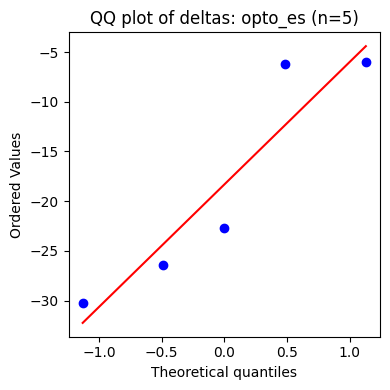

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# assumes prefix_mean exists with columns: condition, Pre_mean, Post_mean
def deltas(prefix_mean, cond):
    sub = prefix_mean[prefix_mean["condition"]==cond][["Pre_mean","Post_mean"]].dropna()
    return (sub["Post_mean"] - sub["Pre_mean"]).to_numpy(float)

for cond in ["es_alone", "opto_es"]:
    d = deltas(prefix_mean, cond)
    fig = plt.figure(figsize=(4,4))
    stats.probplot(d, dist="norm", plot=plt)
    plt.title(f"QQ plot of deltas: {cond} (n={len(d)})")
    plt.tight_layout()
    plt.show()


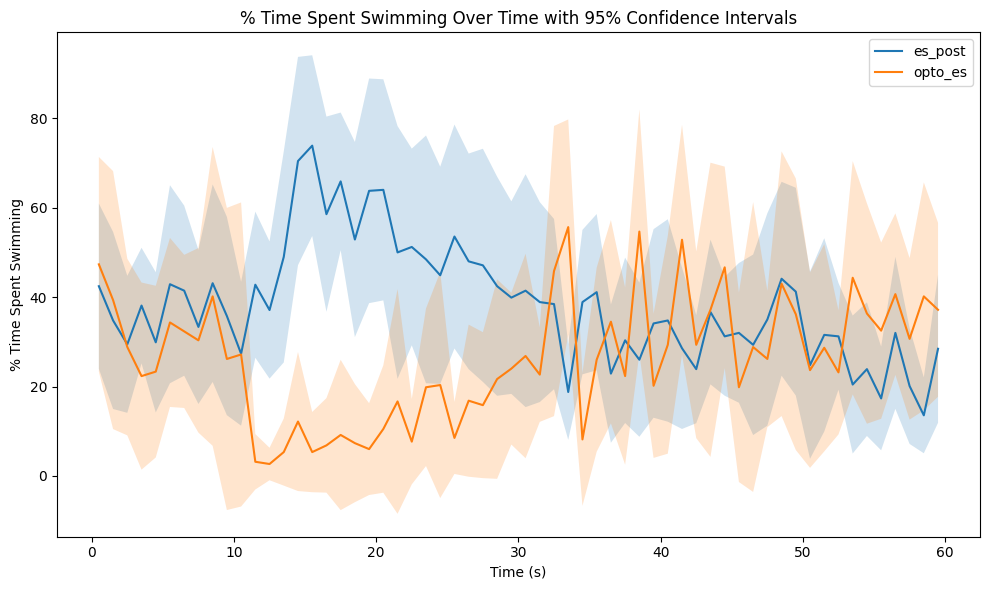

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load per-second time-series file (change path if needed)
df = pd.read_csv("C:/Maha/DATA/electric_stim/tracking_bout_detection/electric_stim_percent_time_swimming_per_file.csv")

# --- KEEP ONLY THESE TRIAL IDs ---
KEEP_IDS = []

df = df[df["file"].astype(str).isin(KEEP_IDS)].copy()

# --- Normalize/alias condition names ---
df["condition"] = df["condition"].astype(str).str.strip().str.lower()
# Treat 'es' or 'es_alone' as 'es_post' so we can plot opto_es vs es_post
df["condition_plot"] = df["condition"].replace({"es": "es_post", "es_alone": "es_post"})

# ---------------------------------------------------------------------
# Filter to the conditions you want (opto_es vs es_post)
filtered_df = df[df["condition_plot"].isin(["opto_es", "es_post"])].copy()

# Ensure numeric types
filtered_df["time_bin"] = pd.to_numeric(filtered_df["time_bin"], errors="coerce")
filtered_df["percent_time_swimming"] = pd.to_numeric(filtered_df["percent_time_swimming"], errors="coerce")
filtered_df = filtered_df.dropna(subset=["time_bin", "percent_time_swimming"])

# Compute mean and 95% CI per (time_bin, condition)
grp = (
    filtered_df
    .groupby(["condition_plot", "time_bin"])["percent_time_swimming"]
    .agg(["mean", "std", "count"])
    .reset_index()
    .rename(columns={"condition_plot": "condition"})
)
grp["se"] = grp["std"] / np.sqrt(grp["count"].clip(lower=1))
grp["ci_low"] = grp["mean"] - 1.96 * grp["se"]
grp["ci_high"] = grp["mean"] + 1.96 * grp["se"]

# Plot
plt.figure(figsize=(10, 6))

for cond in grp["condition"].unique():
    sub = grp[grp["condition"] == cond].sort_values("time_bin")
    # Mean line
    plt.plot(sub["time_bin"], sub["mean"], label=cond)
    # 95% CI band
    plt.fill_between(sub["time_bin"], sub["ci_low"], sub["ci_high"], alpha=0.2)

# Optional: vertical lines for stimuli
# stim_times = [183, 366, 549]
# for i, t in enumerate(stim_times):
#     plt.axvline(t, linestyle="--", alpha=0.8, label="Stimulus" if i == 0 else None)

plt.xlabel("Time (s)")
plt.ylabel("% Time Spent Swimming")
plt.title("% Time Spent Swimming Over Time with 95% Confidence Intervals")
plt.legend()
plt.tight_layout()

# Save (adjust paths as needed)
#pdf_path = r"C:\Maha\DATA\electric_stim\tracking_bout_detection\percent_time_swimming_time_series.pdf"
#svg_path = r"C:\Maha\DATA\electric_stim\tracking_bout_detection\percent_time_swimming_time_series.svg"

# Create directories if they don't exist
for p in [pdf_path, svg_path]:
    folder = os.path.dirname(p)
    if folder and not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

plt.savefig(pdf_path)
plt.savefig(svg_path)
plt.show()




In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

# ----------------- INPUT -----------------
IN_CSV = Path(r"C:\Maha\DATA\electric_stim\tracking_bout_detection\percent_time_swimming_filtered_KEEP_IDS.csv")
OUT_CSV = IN_CSV.parent / "first_intersections_after_11s_per_prefix.csv"

STIM_START = 11.0  # seconds

# CONDITIONS TO INTERSECT (change here if needed)
COND_A = "es_alone"
COND_B = "opto_es"

# ----------------- LOAD -----------------
df = pd.read_csv(IN_CSV)

# expected columns
need = {"file", "condition", "time_bin", "percent_time_swimming"}
missing = need - set(df.columns)
if missing:
    raise SystemExit(f"Missing columns in {IN_CSV.name}: {sorted(missing)}")

# prefix from filename: F1, F2, F8, F10, ...
df["file"] = df["file"].astype(str).str.strip()
df["prefix"] = df["file"].str.extract(r"^(F\d+)", expand=False)

# normalize condition names
df["condition"] = df["condition"].astype(str).str.strip().str.lower()

# OPTIONAL mapping: only if you have 'es' values that should count as es_alone
df["condition"] = df["condition"].replace({"es": "es_alone"})

# keep only the two conditions we want to intersect
df = df[df["condition"].isin([COND_A, COND_B])].copy()
if df.empty:
    raise SystemExit(f"No rows for conditions {COND_A} and {COND_B} after filtering.")

# numeric cleanup
df["time_bin"] = pd.to_numeric(df["time_bin"], errors="coerce")
df["percent_time_swimming"] = pd.to_numeric(df["percent_time_swimming"], errors="coerce")
df = df.dropna(subset=["prefix", "time_bin", "percent_time_swimming"]).copy()

# ----------------- MEAN TRACE PER PREFIX + CONDITION -----------------
mean_ts = (
    df.groupby(["prefix", "condition", "time_bin"], as_index=False)["percent_time_swimming"]
      .mean()
)

# pivot to get both conditions as columns
pv = mean_ts.pivot_table(
    index=["prefix", "time_bin"],
    columns="condition",
    values="percent_time_swimming",
    aggfunc="mean"
).reset_index()

# make sure both columns exist; otherwise explain what exists
cols = set(pv.columns)
if COND_A not in cols or COND_B not in cols:
    present = sorted([c for c in pv.columns if c not in ("prefix", "time_bin")])
    raise SystemExit(
        f"Pivot is missing required columns. Needed: [{COND_A}, {COND_B}]. Present: {present}\n"
        f"Tip: check your df['condition'].unique() before pivot."
    )

# keep only rows where both conditions exist
pv = pv.dropna(subset=[COND_A, COND_B]).copy()

# ----------------- FIRST INTERSECTION AFTER STIM_START -----------------
def first_intersection_time_after(t, y1, y2, t_min=11.0):
    t = np.asarray(t, dtype=float)
    d = np.asarray(y1, dtype=float) - np.asarray(y2, dtype=float)

    m = t >= t_min
    t = t[m]
    d = d[m]
    if len(t) < 2:
        return np.nan

    # exact hit
    z = np.where(np.isclose(d, 0.0, atol=1e-12))[0]
    if z.size:
        return float(t[z[0]])

    s = np.sign(d)
    for i in range(1, len(s)):
        if s[i] == 0:
            s[i] = s[i-1]

    changes = np.where(s[:-1] * s[1:] < 0)[0]
    if changes.size == 0:
        return np.nan

    i = int(changes[0])
    t1, t2 = t[i], t[i+1]
    d1, d2 = d[i], d[i+1]
    return float(t1 + (0 - d1) * (t2 - t1) / (d2 - d1))

rows = []
for prefix, sub in pv.groupby("prefix"):
    sub = sub.sort_values("time_bin")
    t = sub["time_bin"].to_numpy()
    yA = sub[COND_A].to_numpy()
    yB = sub[COND_B].to_numpy()
    inter_t = first_intersection_time_after(t, yA, yB, t_min=STIM_START)
    rows.append({"prefix": prefix, "intersection_time_sec": inter_t})

out = pd.DataFrame(rows).sort_values("intersection_time_sec", na_position="last")

print("=== First intersections after 11 s (per prefix) ===")
print(out.to_string(index=False, float_format=lambda x: f"{x:.2f}" if np.isfinite(x) else "nan"))

out.to_csv(OUT_CSV, index=False)
print(f"\nSaved: {OUT_CSV}")


=== First intersections after 11 s (per prefix) ===
prefix  intersection_time_sec
    F1                  11.50
   F11                  22.17
    F8                  31.50
   F10                  47.50
    F2                  50.50

Saved: C:\Maha\DATA\electric_stim\tracking_bout_detection\first_intersections_after_11s_per_prefix.csv


In [27]:
import numpy as np
import pandas as pd

# Use the intersections DataFrame produced earlier:
if "intersections" not in globals() or intersections.empty:
    raise RuntimeError("No intersections found in memory. Run the intersection-finder first.")

x = pd.to_numeric(intersections["intersection_time_sec"], errors="coerce").dropna().to_numpy(float)
n = x.size
std = x.std(ddof=1) if n > 1 else np.nan
sem = (std / np.sqrt(n)) if n > 1 else np.nan

summary = pd.DataFrame([{
    "n": n,
    "mean_s": x.mean() if n else np.nan,
    "sem_s": sem,
    "median_s": float(np.median(x)) if n else np.nan,
    "std_s": std
}])

print(summary.to_string(index=False, float_format=lambda v: f"{v:.3f}"))


 n  mean_s  sem_s  median_s  std_s
 5  15.601  2.460    12.096  5.501


C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_11804\703053105.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_11804\703053105.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["First intersections after 11 s"])


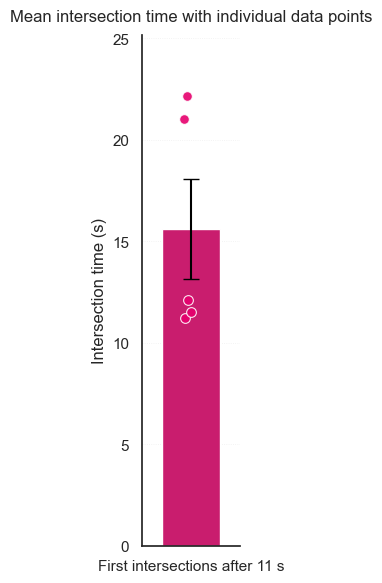

Saved SVG: C:\Maha\DATA\electric_stim\tracking_bout_detection\intersection_time_bar_with_points.svg
Saved PDF: C:\Maha\DATA\electric_stim\tracking_bout_detection\intersection_time_bar_with_points.pdf


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# === your data ===
df = pd.DataFrame({
    "prefix": ["F8", "F1", "F10", "F2", "F11"],
    "intersection_time_sec": [11.21, 11.50, 12.10, 21.03, 22.17]
})
df["group"] = "First intersections after 11 s"

# === output path ===
OUT_DIR = Path(r"C:\Maha\DATA\electric_stim\tracking_bout_detection")
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_SVG = OUT_DIR / "intersection_time_bar_with_points.svg"
FIG_PDF = OUT_DIR / "intersection_time_bar_with_points.pdf"

# === colors & style ===
PINK = "#e6006d"
sns.set_theme(style="white", rc={
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linewidth": 0.6,
    "grid.linestyle": ":"
})

# === compute mean & SEM ===
mean_val = df["intersection_time_sec"].mean()
sem_val = df["intersection_time_sec"].std(ddof=1) / np.sqrt(len(df))

# === plot ===
fig, ax = plt.subplots(figsize=(2, 6))

# Bar (mean)
sns.barplot(
    data=df, x="group", y="intersection_time_sec",
    color=PINK, width=0.6, ci=None, ax=ax, zorder=1
)

# SEM error bar
ax.errorbar(
    x=0, y=mean_val, yerr=sem_val,
    fmt="none", ecolor="black", elinewidth=1.5, capsize=6, zorder=2
)

# Individual points
sns.stripplot(
    data=df, x="group", y="intersection_time_sec",
    color=PINK, size=7, jitter=0.08, alpha=0.9,
    edgecolor="white", linewidth=0.8, ax=ax, zorder=3
)



# Cosmetics
ax.set_xlabel("")
ax.set_ylabel("Intersection time (s)")
ax.set_xticklabels(["First intersections after stim"])
ax.set_title("Mean intersection time with individual data points", pad=10)

# Limits
ymax = np.nanmax(df["intersection_time_sec"])
ax.set_ylim(0, ymax + 3)

plt.tight_layout()

# === save ===
fig.savefig(FIG_SVG)
fig.savefig(FIG_PDF, dpi=300)
plt.show()

print(f"Saved SVG: {FIG_SVG}\nSaved PDF: {FIG_PDF}")
